Start this first
```bash
$ litex_server uart /dev/ttyUSB0 1152000
```

In [1]:
%pylab notebook
from litex.soc.tools.remote import RemoteClient
from struct import pack, unpack
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
for i in range(32):
    try:
        r = RemoteClient(csr_csv="build/csr.csv", debug=False, port=1234 + i)
        r.open()
        print("Connected to Port", 1234 + i)
        break
    except ConnectionRefusedError:
        pass

def getId():
    s = ""
    for i in range(64):
        temp = r.read(r.bases.identifier_mem + i * 4)
        if temp == 0:
            break
        s += chr(temp & 0xFF)
    return s
getId()

Connected to Port 1234


'LTC2175 demonstrator 2019-04-05 18:38:57'

# Setup SPI

In [3]:
# config bits
OFFLINE      = 0  # all pins high-z (reset=1)
CS_POLARITY  = 3  # active level of chip select (reset=0)
CLK_POLARITY = 4  # idle level of clk (reset=0)
CLK_PHASE    = 5  # first edge after cs assertion to sample data on (reset=0)
LSB_FIRST    = 6  # LSB is the first bit on the wire (reset=0)
HALF_DUPLEX  = 7  # 3-wire SPI, in/out on mosi (reset=0)
DIV_READ     = 16 # SPI read clk divider (reset=0)
DIV_WRITE    = 24 # f_clk / f_spi_write == div_write + 2
# xfer bits
CS_MASK      =  0 # Active high bit mask of chip selects to assert (reset=0)
WRITE_LENGTH = 16 # How many bits to write and ...
READ_LENGTH  = 24 # when to switch over in half duplex mode

r.regs.spi_config.write((0xFF << DIV_WRITE) | (0xFF << DIV_READ))

# 16 bit write transfer (includes read as is 4 wire)
r.regs.spi_xfer.write((0 << READ_LENGTH) | (0x10 << WRITE_LENGTH) | (0xFFFF << CS_MASK))

def set_ltc_reg(adr, val):
    word = (0 << 15) | ((adr & 0x7F) << 8) | (val & 0xFF)
    word <<= 16
    r.regs.spi_mosi_data.write(word)
    r.regs.spi_start.write(1)

def get_ltc_reg(adr):
    word = (1 << 15) | ((adr & 0x7F) << 8)
    word <<= 16
    r.regs.spi_mosi_data.write(word)
    r.regs.spi_start.write(1)
    return r.regs.spi_miso_data.read() & 0xFF

def setTp(tpValue):
    set_ltc_reg(3, (1<<7) | tpValue >> 8)   # Test pattern on + value MSB
    set_ltc_reg(4, tpValue & 0xFF)          # Test pattern value LSB
    
def myzip(*vals):
    """
    interleave elements in a flattened list

    >>> myzip([1,2,3], ['a', 'b', 'c'])
    [1, 'a', 2, 'b', 3, 'c']
    """
    return [i for t in zip(*vals) for i in t]

def getInt32(I):
    """ 
    recover sign from twos complement integer
    >>> getInt32(0xFFFFFFFF)
    -1
    """
    return unpack("i", pack("I", I))[0]

# Dump LTC2175 registers

In [4]:
for i in range(5):
    print("{:2x}: {:02x}".format(i, get_ltc_reg(i)))

 0: 00
 1: 00
 2: 00
 3: 00
 4: 00


In [5]:
set_ltc_reg(0, 0x80)   # Software reset

In [ ]:
set_ltc_reg(1, 0x10)   # Sleep mode

In [ ]:
set_ltc_reg(1, 0x00)   # Waky waky

# Measure sample clock frequency [Hz]

In [6]:
r.regs.lvds_f_sample_value.read()

114285715

# Read and align clock data

In [10]:
rVal = r.regs.lvds_clk_peek.read()
print("0x{0:02X} 0b{0:08b}".format(rVal))

0x0F 0b00001111


do a bitslip until we get 0x0F

In [9]:
r.regs.lvds_bitslip_csr.write(1)

# Map data lanes
Check that each bit in the test-pattern end up in the right place in the output word

In [11]:
for i in range(14):
    tpValue = 1 << i
    setTp(tpValue)
    rVal = r.regs.lvds_data_peek.read()
    print("{:016b} {:016b}".format(tpValue, rVal))

0000000000000001 0000000000000100
0000000000000010 0000000000001000
0000000000000100 0000000000010000
0000000000001000 0000000000100000
0000000000010000 0000000001000000
0000000000100000 0000000010000000
0000000001000000 0000000100000000
0000000010000000 0000001000000000
0000000100000000 0000010000000000
0000001000000000 0000100000000000
0000010000000000 0001000000000000
0000100000000000 0010000000000000
0001000000000000 0100000000000000
0010000000000000 1000000000000000


# Read ADC sample

In [12]:
set_ltc_reg(3, 0)   # Test pattern off
set_ltc_reg(1, 0)   # Randomizer off

In [15]:
# Lowest 2 bits are always zero in 16 bit LVDS mode
# 12 bit ADC, so next 2 bits are also zero
rVal = r.regs.lvds_data_peek.read() >> 4
print("0x{0:03x} 0b{0:012b}".format(rVal))
# Decode offset binary mode
print(rVal - (1 << 11))

0x226 0b001000100110
-1498


# Read randomized ADC sample

In [ ]:
set_ltc_reg(1, (1<<6))   # Randomizer on

In [ ]:
rVal = r.regs.lvds_data_peek.read() >> 4
print("0x{0:03x} 0b{0:012b}".format(rVal))
# XOR LSB with any other bit
if rVal & 0x01:
    rVal ^= 0xFFE
# Decode offset binary mode
print(rVal - (1 << 11))

# Read phase detectors
Make sure to disable the test-pattern to get transitions on all LVDS lanes

In [19]:
integr = 2**22
r.regs.lvds_pd_period_csr.write(integr)
r.regs.lvds_pd_period_csr.read()

4194304

In [20]:
def printPd():
    val0 = getInt32(r.regs.lvds_pd_phase_0.read()) / integr
    val1 = getInt32(r.regs.lvds_pd_phase_1.read()) / integr
    print("\r{:0.3f}  {:0.3f}          ".format(val0, val1), end="")
    return val0, val1

In [36]:
val0, val1 = printPd()

0.361  -0.382          

# Control Idelays manually

In [ ]:
# Choose channel
r.regs.lvds_idelay_mux.write(1)
r.regs.lvds_idelay_mux.read()

In [ ]:
r.regs.lvds_idelay_inc.write(0)   # Increment delay

In [ ]:
r.regs.lvds_idelay_dec.write(0)   # Decrement delay

In [ ]:
printPd()

# Control Idelays automatically
Let the gateware step up / down the idelays and monitor the phase detector values

In [16]:
r.regs.lvds_idelay_auto.write(1)

In [ ]:
# Enable / disable auto phase tracking mode
r.regs.lvds_idelay_auto.write(1)
# Print phase
p0s = []
p1s = []
while True:
    val0, val1 = printPd()
    p0s.append(val0)
    p1s.append(val1)
    time.sleep(0.1)

In [ ]:
r.regs.lvds_idelay_auto.write(0)
close("all")
plot(p0s, "-o")
plot(p1s, "-o")

# Scope plot

<IPython.core.display.Javascript object>


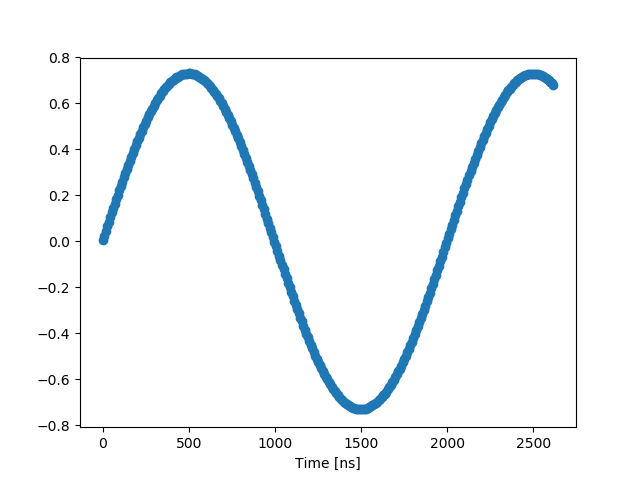

In [39]:
from matplotlib.animation import FuncAnimation

def setTriggerLevel(l):
    """ -1 < l < 1 """
    tl = int((l + 1) * (1 << 15))
    print(tl)
    r.regs.acq_trig_level.write(tl)
    
def getSamples(N=None):
    """ why doesn't RemoteClient take care of chunking for me ??? """
    if N is None:
        N = r.mems.sample.size
    o = r.mems.sample.base
    r.regs.acq_trig_csr.write(0)
    samples = []
    while N:
        temp = r.read(o, min(255, N))
        o += len(temp) * 4  # in bytes!
        N -= len(temp)
        samples.append(temp)
    samples = hstack(samples)
    return samples / (1<<15) - 1 

def ani(i, N):
    l.set_ydata(getSamples(N))

close("all")
N = 300
fSample = 800e6 / 7
xVect = linspace(0, N / fSample, N, endpoint=False)
l, = plot(xVect * 1e9, getSamples(N), "-o")
xlabel("Time [ns]")
FuncAnimation(gcf(), ani, interval=200, fargs=(N,))

In [50]:
setTriggerLevel(0)

32768


In [ ]:
r.close()